In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import sqlite3
import seaborn as sns
import plotly.express as px

download data from here and save in the same folder of this file:
https://www.kaggle.com/michaelschmidek/sql-data-analysis-nba/data

In [3]:
# you might need to pip install the following libraries
#pip install plotly.express
#pip install kaleido

In [4]:
#path = ".." #Everything preceding the file name
database = 'basketball.sqlite' #The path + the file name

# sqlite3.connect() Creates a connection object
# database is the variable we established above
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables
#usless tables: Team (redundant info), Player_Photos, News_Missing, news(earliest is this year april)
# Team_Salary, Player_Salary (only has 2020 and later), Team_History

,type,name,tbl_name,rootpage,sql
0,table,Player,Player,2,"CREATE TABLE ""Player"" (\n""id"" TEXT,\n ""full_n..."
1,table,Team,Team,4,"CREATE TABLE ""Team"" (\n""id"" TEXT,\n ""full_nam..."
2,table,Team_Attributes,Team_Attributes,5,"CREATE TABLE ""Team_Attributes"" (\n""ID"" TEXT,\n..."
3,table,Team_History,Team_History,6,"CREATE TABLE ""Team_History"" (\n""ID"" TEXT,\n ""..."
4,table,Player_Attributes,Player_Attributes,15,"CREATE TABLE ""Player_Attributes"" (\n""ID"" TEXT,..."
5,table,Game_Officials,Game_Officials,8375,"CREATE TABLE ""Game_Officials"" (\n""OFFICIAL_ID""..."
6,table,Game_Inactive_Players,Game_Inactive_Players,8997,"CREATE TABLE ""Game_Inactive_Players"" (\n""PLAYE..."
7,table,Team_Salary,Team_Salary,13415,CREATE TABLE `Team_Salary` (\n `nameTeam` TEX...
8,table,Player_Salary,Player_Salary,23558,CREATE TABLE `Player_Salary` (\n `slugSeason`...
9,table,Draft,Draft,23559,"CREATE TABLE `Draft` (\n `yearDraft` REAL,\n ..."


In [64]:
Player = pd.read_sql("""
    SELECT *
    from Player
    where id = 2544
   -- limit 20;
""", conn)
# remove team id = 0
# not sure if need is_active (is this is active for current season?)
print(pd.read_sql("""SELECT count(*) FROM Player_Attributes;""", conn))

Player

   count(*)
0      4500


,id,full_name,first_name,last_name,is_active
0,2544,LeBron James,LeBron,James,1


In [90]:
Player_Attributes = pd.read_sql("""
    SELECT 
    pa.ID, p.is_active, cast(BIRTHDATE as date) as BIRTHDATE, HEIGHT, WEIGHT, JERSEY, POSITION,SCHOOL, COUNTRY, 
    TEAM_ID, GAMES_PLAYED_CURRENT_SEASON_FLAG,SEASON_EXP,
    FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,
    DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
    FROM Player_Attributes pa
    left join Player p on p.id = pa.id
    where team_id <>0
    
    limit 20;
""", conn)
# remove team id = 0
# not sure if need is_active (is this is active for current season?)
print(pd.read_sql("""SELECT count(*) FROM Player_Attributes;""", conn))

Player_Attributes

   count(*)
0      4500


,ID,is_active,BIRTHDATE,HEIGHT,WEIGHT,JERSEY,POSITION,SCHOOL,COUNTRY,TEAM_ID,...,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
0,76001,0,1968,82.0,240.0,30,Forward,Duke,USA,1610612757,...,Y,Y,1990,1,25,5.7,0.3,3.3,0.0,NaN
1,76002,0,1946,81.0,235.0,54,Center,Iowa State,USA,1610612745,...,Y,Y,1968,1,5,9.0,1.2,8.0,0.0,NaN
2,76003,0,1947,86.0,225.0,33,Center,UCLA,USA,1610612747,...,Y,Y,1969,1,1,24.6,3.6,11.2,18.0,NaN
3,51,0,1969,73.0,162.0,1,Guard,Louisiana State,USA,1610612743,...,Y,Y,1990,1,3,14.6,3.5,1.9,0.0,NaN
4,1505,0,1974,78.0,235.0,9,Forward-Guard,San Jose State,France,1610612758,...,Y,Y,1997,1,11,7.8,1.1,3.3,0.0,NaN
5,949,0,1976,81.0,245.0,3,Forward,California,USA,1610612763,...,Y,Y,1996,1,3,18.1,2.5,7.5,1.0,NaN
6,76005,0,1954,79.0,220.0,5,Forward,Indiana,USA,1610612744,...,Y,Y,1976,3,43,5.6,1.2,3.2,0.0,NaN
7,76006,0,1932,75.0,180.0,6,Guard,Western Kentucky,USA,1610612755,...,Y,Y,1956,None,None,0.0,1.0,1.0,0.0,NaN
8,76007,0,1919,75.0,195.0,,Forward,Salem,USA,1610610031,...,Y,Y,Undrafted,Undrafted,Undrafted,9.5,0.7,NaN,0.0,NaN
9,101165,0,1983,77.0,185.0,3,Guard,Pepperdine,USA,1610612746,...,Y,Y,2005,2,60,2.7,0.5,1.0,0.0,NaN


In [66]:
Team_Attributes = pd.read_sql("""SELECT id, ABBREVIATION, NICKNAME,YEARFOUNDED, CITY, ARENA, ARENACAPACITY, OWNER,
                                    GENERALMANAGER, HEADCOACH, DLEAGUEAFFILIATION
                        FROM Team_Attributes
                        """, conn)
Team_Attributes
# 30 count

,ID,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,1610612737,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Nate McMillan,Erie Bayhawks
1,1610612738,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,1610612739,CLE,Cavaliers,1970,Cleveland,Rocket Mortgage FieldHouse,20562.0,Dan Gilbert,Koby Altman,JB Bickerstaff,Canton Charge
3,1610612740,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Stan Van Gundy,No Affiliate
4,1610612741,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Arturas Karnisovas,Billy Donovan,Windy City Bulls
5,1610612742,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends
6,1610612743,DEN,Nuggets,1976,Denver,Ball Arena,NaN,Stan Kroenke,Tim Connelly,Michael Malone,No Affiliate
7,1610612744,GSW,Warriors,1946,Golden State,Chase Center,NaN,Joe Lacob,Bob Myers,Steve Kerr,Santa Cruz Warriors
8,1610612745,HOU,Rockets,1967,Houston,Toyota Center,18104.0,Tilman Fertitta,Rafael Stone,Stephen Silas,Rio Grande Valley Vipers
9,1610612746,LAC,Clippers,1970,Los Angeles,STAPLES Center,19060.0,Steve Ballmer,Michael Winger,Tyronn Lue,Agua Caliente Clippers of Ontario


In [74]:
Game_Officials = pd.read_sql("""
    with official as (
        SELECT GAME_ID, official_id, jersey_num, row_number() over(partition by game_id order by official_id) as rnk
        FROM Game_Officials
    )
    select o1.game_id, o1.official_id as official_id_1, o2.official_id as official_id_2, o3.official_id as official_id_3
    from
        official o1
        left join official o2 on o1.game_id = o2.game_id and o2.rnk = 2
        left join official o3 on o1.game_id = o3.game_id and o3.rnk = 3
    where 
        o1.rnk = 1
    limit 20
;""", conn)
# maybe wining has to do with officials?
print(pd.read_sql("""SELECT count(*) FROM Game_Officials;""", conn))
Game_Officials

   count(*)
0     65158


,GAME_ID,official_id_1,official_id_2,official_id_3
0,0020000020,1180,1181,1185
1,0020000023,1142,1151,1193
2,0020000057,1157,1199,1830
3,0020000089,1180,1181,1185
4,0020000090,1144,1158,1201
5,0020000136,1161,1186,1662
6,0020000146,1165,1179,1194
7,0020000149,1144,1148,1156
8,0020000256,1165,1186,1662
9,0020000265,1154,1184,1188


In [68]:
Game_Inactive_Players = pd.read_sql("""
    SELECT GAME_ID, TEAM_ID, count(distinct PLAYER_ID) as inactive_player_count --,JERSEY_NUM
    FROM Game_Inactive_Players
    group by 1,2
    order by game_id, team_id 
    limit 20
    ;""", conn)
# count the number of inactive players per game
print(pd.read_sql("""SELECT count(*) FROM Game_Inactive_Players;""", conn))
Game_Inactive_Players

   count(*)
0     98679


,GAME_ID,TEAM_ID,inactive_player_count
0,0020000006,1610612758,1
1,0020000018,1610612758,1
2,0020000089,1610612739,1
3,0020000098,1610612745,1
4,0020000105,1610612739,2
5,0020000105,1610612744,2
6,0020000109,1610612753,1
7,0020000120,1610612761,1
8,0020000127,1610612748,1
9,0020000155,1610612739,1


In [47]:
Player_Bios = pd.read_sql("""SELECT namePlayerBREF, nameTable, numberTransactionPlayer,dateTransaction, descriptionTransaction,
                        isGLeagueMovement,isDraft
                        FROM Player_Bios
                        limit 20;""", conn)

print(pd.read_sql("""SELECT count(*) FROM Player_Bios;""", conn))
Player_Bios

   count(*)
0     42749


,namePlayerBREF,nameTable,numberTransactionPlayer,dateTransaction,descriptionTransaction,isGLeagueMovement,isDraft
0,A.C. Green,Transactions,1.0,5647.0,Drafted by the Los Angeles Lakers in the 1st r...,0.0,1.0
1,A.C. Green,Transactions,2.0,8602.0,Released by the Los Angeles Lakers.,0.0,0.0
2,A.C. Green,Transactions,3.0,8671.0,Signed as an unrestricted free agent with the ...,0.0,0.0
3,A.C. Green,Transactions,4.0,9856.0,"Traded by the Phoenix Suns with Sam Cassell, M...",0.0,0.0
4,A.C. Green,Transactions,5.0,10835.0,Traded by the Dallas Mavericks to the Los Ange...,0.0,0.0
5,A.C. Green,Transactions,6.0,11261.0,Signed as a free agent with the Miami Heat.,0.0,0.0
6,A.C. Green,Salaries,NaN,NaN,None,NaN,NaN
7,A.C. Green,Salaries,NaN,NaN,None,NaN,NaN
8,A.C. Green,Salaries,NaN,NaN,None,NaN,NaN
9,A.C. Green,Salaries,NaN,NaN,None,NaN,NaN


In [88]:
Draft = pd.read_sql("""
    SELECT distinct cast(yearDraft as int) as yearDraft, cast(idTeam as int) as idTeam,
    count(distinct idPlayer) as Number_of_Picks
    FROM Draft
    group by 1,2
    limit 20
    ;""", conn)

print(pd.read_sql("""SELECT count(*) FROM Draft;""", conn))
Draft

   count(*)
0      7890


,yearDraft,idTeam,Number_of_Picks
0,1949,1610610024,8
1,1949,1610610025,3
2,1949,1610610030,8
3,1949,1610610032,9
4,1949,1610610034,10
5,1949,1610610036,5
6,1949,1610612738,11
7,1949,1610612744,3
8,1949,1610612747,3
9,1949,1610612752,8


In [18]:
Game = pd.read_sql("""
SELECT  
    --IDs and basic info for joining
   GAME_ID,SEASON_ID,TEAM_ID_HOME,TEAM_ID_AWAY,GAME_DATE,SEASON,
   LAST_GAME_ID,LAST_GAME_HOME_TEAM_ID,LAST_GAME_VISITOR_TEAM_ID,LAST_GAME_DATE_EST,
   
   -- outcome variables
   WL_HOME, PTS_HOME,PTS_AWAY, PLUS_MINUS_HOME, --margin
   
   MIN_HOME,MIN_AWAY,GAME_SEQUENCE, GAME_STATUS_TEXT,ATTENDANCE,
   --DATE_PART('WEEKDAY', GAME_DATE) as game_weekday,
   
   FGM_HOME,FGA_HOME,FG_PCT_HOME,
   FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,
   DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,
   
   FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,
   FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,
   DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,
   
   PTS_PAINT_HOME,PTS_2ND_CHANCE_HOME,PTS_FB_HOME,LARGEST_LEAD_HOME,
   LEAD_CHANGES_HOME,TIMES_TIED_HOME,TEAM_TURNOVERS_HOME,TOTAL_TURNOVERS_HOME,
   TEAM_REBOUNDS_HOME,PTS_OFF_TO_HOME,
   
   PTS_PAINT_AWAY,PTS_2ND_CHANCE_AWAY,
   PTS_FB_AWAY,LARGEST_LEAD_AWAY,LEAD_CHANGES_AWAY,TIMES_TIED_AWAY,TEAM_TURNOVERS_AWAY,
   TOTAL_TURNOVERS_AWAY,TEAM_REBOUNDS_AWAY,PTS_OFF_TO_AWAY,
   
   PTS_QTR1_HOME,PTS_QTR2_HOME,PTS_QTR3_HOME,PTS_QTR4_HOME,PTS_OT1_HOME,PTS_OT2_HOME,
   PTS_OT3_HOME,PTS_OT4_HOME,
   PTS_QTR1_AWAY,PTS_QTR2_AWAY,PTS_QTR3_AWAY,PTS_QTR4_AWAY,
   PTS_OT1_AWAY,PTS_OT2_AWAY,PTS_OT3_AWAY,PTS_OT4_AWAY,
   
   LAST_GAME_HOME_TEAM_POINTS,LAST_GAME_VISITOR_TEAM_POINTS,HOME_TEAM_WINS,HOME_TEAM_LOSSES,
   SERIES_LEADER, PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS
   
  FROM Game
    where GAME_DATE >= '1996-11-01' -- where most of the field start to have data
   -- limit 20
    
    ;""", conn)

#print(pd.read_sql("""SELECT count(*) FROM Game;""", conn))

for col in Game.columns:
    print(col)

#should remove null and na
Game
Game.to_csv('game.csv', sep=',')


GAME_ID
SEASON_ID
TEAM_ID_HOME
TEAM_ID_AWAY
GAME_DATE
SEASON
LAST_GAME_ID
LAST_GAME_HOME_TEAM_ID
LAST_GAME_DATE_EST
WL_HOME
PTS_HOME
PTS_AWAY
PLUS_MINUS_HOME
MIN_HOME
MIN_AWAY
GAME_SEQUENCE
GAME_STATUS_TEXT
ATTENDANCE
FGM_HOME
FGA_HOME
FG_PCT_HOME
FG3M_HOME
FG3A_HOME
FG3_PCT_HOME
FTM_HOME
FTA_HOME
FT_PCT_HOME
OREB_HOME
DREB_HOME
REB_HOME
AST_HOME
STL_HOME
BLK_HOME
TOV_HOME
PF_HOME
FGM_AWAY
FGA_AWAY
FG_PCT_AWAY
FG3M_AWAY
FG3A_AWAY
FG3_PCT_AWAY
FTM_AWAY
FTA_AWAY
FT_PCT_AWAY
OREB_AWAY
DREB_AWAY
REB_AWAY
AST_AWAY
STL_AWAY
BLK_AWAY
TOV_AWAY
PF_AWAY
PTS_PAINT_HOME
PTS_2ND_CHANCE_HOME
PTS_FB_HOME
LARGEST_LEAD_HOME
LEAD_CHANGES_HOME
TIMES_TIED_HOME
TEAM_TURNOVERS_HOME
TOTAL_TURNOVERS_HOME
TEAM_REBOUNDS_HOME
PTS_OFF_TO_HOME
PTS_PAINT_AWAY
PTS_2ND_CHANCE_AWAY
PTS_FB_AWAY
LARGEST_LEAD_AWAY
LEAD_CHANGES_AWAY
TIMES_TIED_AWAY
TEAM_TURNOVERS_AWAY
TOTAL_TURNOVERS_AWAY
TEAM_REBOUNDS_AWAY
PTS_OFF_TO_AWAY
PTS_QTR1_HOME
PTS_QTR2_HOME
PTS_QTR3_HOME
PTS_QTR4_HOME
PTS_OT1_HOME
PTS_OT2_HOME
PTS_OT3_HOME
PTS_O

--pre 2005 vs post
-- identify outlier (covid seasons)


In [21]:
Game.head()

,GAME_ID,SEASON_ID,TEAM_ID_HOME,TEAM_ID_AWAY,GAME_DATE,SEASON,LAST_GAME_ID,LAST_GAME_HOME_TEAM_ID,LAST_GAME_DATE_EST,WL_HOME,...,PTS_OT4_AWAY,LAST_GAME_HOME_TEAM_POINTS,LAST_GAME_VISITOR_TEAM_ID,LAST_GAME_VISITOR_TEAM_POINTS,HOME_TEAM_WINS,HOME_TEAM_LOSSES,SERIES_LEADER,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS
0,0029600002,21996,1610612751,1610612739,1996-11-01,1996,0029500765,1610612751,1996-02-24T00:00:00,L,...,0,74,1610612739,103,0.0,4.0,Cleveland,0.0,0.0,0.0
1,0029600009,21996,1610612745,1610612758,1996-11-01,1996,0029501059,1610612745,1996-04-05T00:00:00,W,...,0,91,1610612758,96,4.0,0.0,Houston,0.0,0.0,0.0
2,0029600010,21996,1610612743,1610612742,1996-11-01,1996,0029501162,1610612743,1996-04-18T00:00:00,L,...,0,98,1610612742,132,1.0,3.0,Dallas,0.0,0.0,0.0
3,0029600011,21996,1610612762,1610612760,1996-11-01,1996,0049500062,1610612762,1996-06-02T00:00:00,W,...,0,86,1610612760,90,3.0,1.0,Utah,0.0,0.0,0.0
4,0029600003,21996,1610612755,1610612749,1996-11-01,1996,0029500680,1610612755,1996-02-13T00:00:00,L,...,0,104,1610612749,101,1.0,3.0,Milwaukee,0.0,0.0,0.0


In [27]:
# dimension
Game.shape

(29465, 97)

In [44]:
# add feature game prior to 2005 rule change
Game['prior_2005'] = Game['SEASON'].astype('int') <2005

In [53]:
#Fill NAs of WL_home
conditions = [
    (Game['PLUS_MINUS_HOME'] < 0),
    (Game['PLUS_MINUS_HOME'] == 0),
    (Game['PLUS_MINUS_HOME'] > 0)
    ]

# create a list of the values we want to assign for each condition
values = ['L', 'T', 'W']

# create a new column and use np.select to assign values to it using our lists as arguments
Game['WL_Home_modified'] = np.select(conditions, values)

In [54]:
Game_modified = Game.copy()

In [55]:
Game_modified = Game_modified.drop(['GAME_ID','SEASON_ID','TEAM_ID_HOME','TEAM_ID_AWAY','SEASON',
                                    'GAME_DATE','LAST_GAME_ID','LAST_GAME_HOME_TEAM_ID',
                                    'LAST_GAME_VISITOR_TEAM_ID','LAST_GAME_DATE_EST',
                                    'PTS_AWAY','PTS_HOME','WL_HOME'], axis = 1)

In [56]:
Game_modified.head()


,PLUS_MINUS_HOME,MIN_HOME,MIN_AWAY,GAME_SEQUENCE,GAME_STATUS_TEXT,ATTENDANCE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,...,LAST_GAME_HOME_TEAM_POINTS,LAST_GAME_VISITOR_TEAM_POINTS,HOME_TEAM_WINS,HOME_TEAM_LOSSES,SERIES_LEADER,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS,prior_2005,WL_Home_modified
0,-13,240,240,2,Final,18316,23.0,58,0.397,9,...,74,103,0.0,4.0,Cleveland,0.0,0.0,0.0,True,L
1,11,240,240,9,Final,16285,34.0,87,0.391,8,...,91,96,4.0,0.0,Houston,0.0,0.0,0.0,True,W
2,-1,240,240,10,Final,16104,28.0,78,0.359,3,...,98,132,1.0,3.0,Dallas,0.0,0.0,0.0,True,L
3,8,240,240,11,Final,19911,34.0,78,0.436,8,...,86,90,3.0,1.0,Utah,0.0,0.0,0.0,True,W
4,-8,240,240,3,Final,20444,37.0,83,0.446,2,...,104,101,1.0,3.0,Milwaukee,0.0,0.0,0.0,True,L


<Figure size 864x576 with 0 Axes>

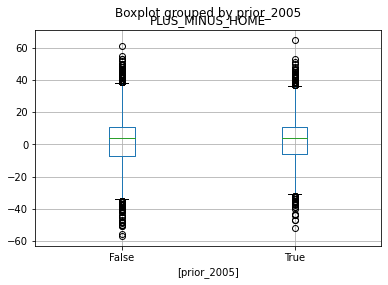

In [61]:
plt.figure(figsize=(12,8))
Game_modified.boxplot(column=['PLUS_MINUS_HOME'], by=['prior_2005'])
plt.show()

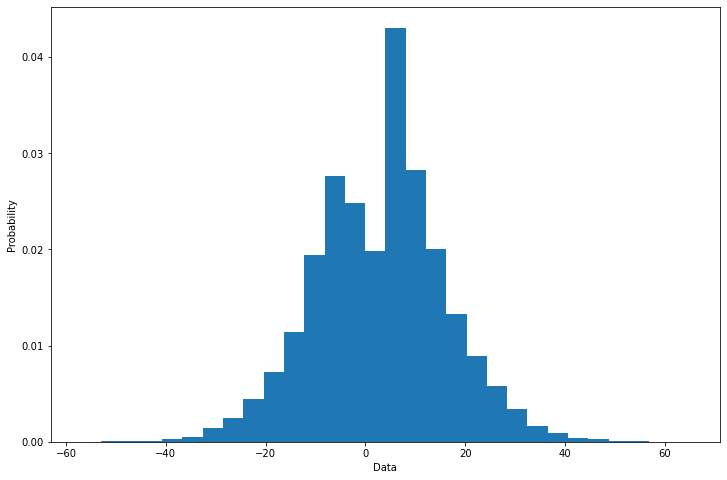

In [62]:
plt.figure(figsize=(12,8))
plt.hist(Game_modified['PLUS_MINUS_HOME'], density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');